## RUL prediction using boosting



In [ ]:
!pip install xgboost==1.7.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.2
    Uninstalling xgboost-2.1.2:
      Successfully uninstalled xgboost-2.1.2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb


## Data Preprocessing


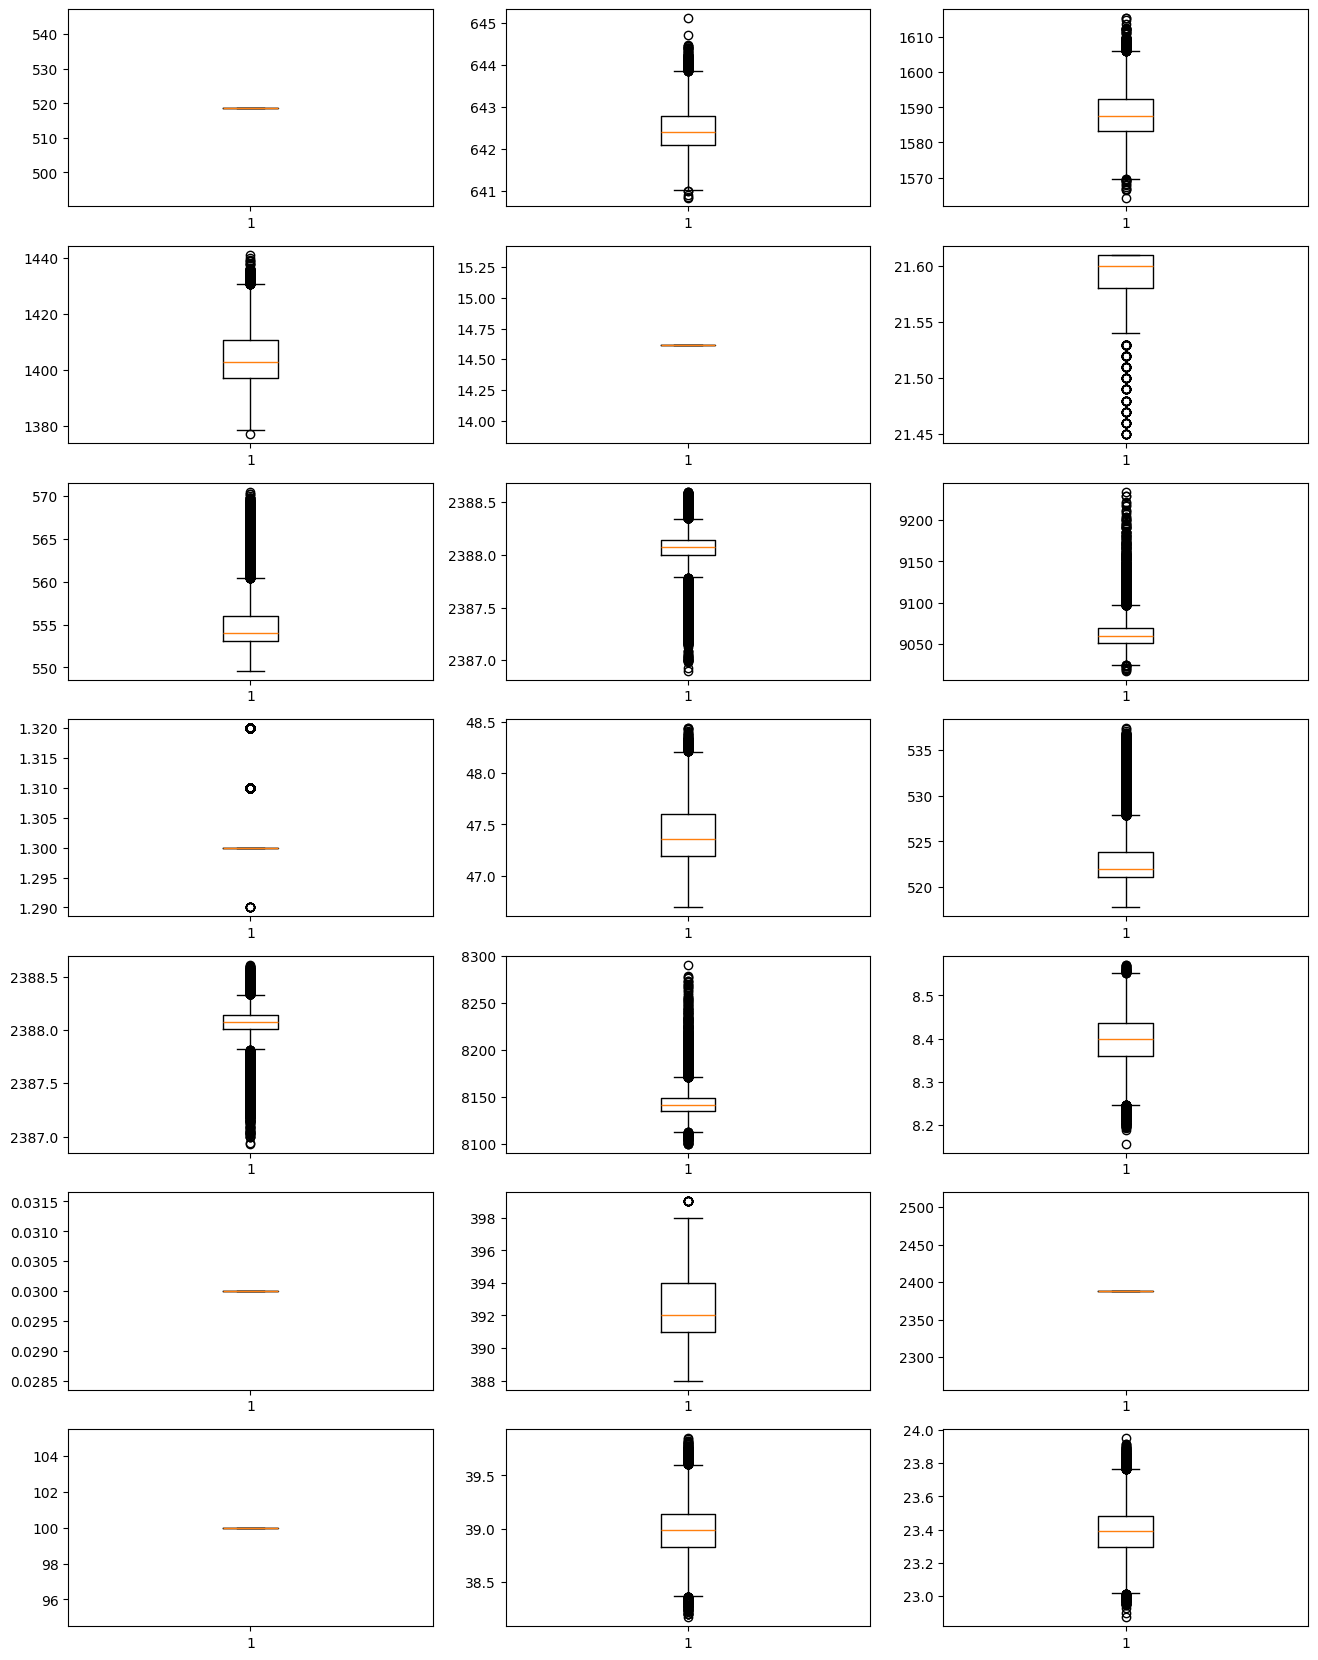

In [ ]:
train_data = pd.read_csv("/content/train_FD003.txt", sep= "\s+", header = None)
plt.figure(figsize = (16, 21))
for i in range(21):
    temp_data = train_data.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(temp_data)
plt.show()

def process_targets(data_length, early_rul = None):

    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):

    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):

    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [ ]:
test_data = pd.read_csv("/content/test_FD003.txt", sep = "\s+", header = None)
true_rul = pd.read_csv('/content/RUL_FD003.txt', sep = '\s+', header = None)

window_length = 30
shift = 1
early_rul = 125
num_test_windows = 5
processed_train_data = []
processed_train_targets = []

num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,14,20,22,23]

num_machines = np.min([len(train_data[0].unique()), len(test_data[0].unique())])

for i in np.arange(1, num_machines + 1):

    temp_train_data = train_data[train_data[0] == i].drop(columns=columns_to_be_dropped).values
    temp_test_data = test_data[test_data[0] == i].drop(columns=columns_to_be_dropped).values

    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    elif (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (21820, 30, 15)
Processed training ruls shape:  (21820,)
Processed test data shape:  (500, 30, 15)
True RUL shape:  (100,)


In [ ]:
# Reshape data for scaling (samples * time steps, features)
num_samples = processed_train_data.shape[0]
num_time_steps = processed_train_data.shape[1]
num_features = processed_train_data.shape[2]
processed_train_data_2D = processed_train_data.reshape(num_samples * num_time_steps, num_features)

# Scale the data
scaler = StandardScaler()
processed_train_data_scaled = scaler.fit_transform(processed_train_data_2D)

# Reshape back to 3D (samples, time steps, features)
processed_train_data = processed_train_data_scaled.reshape(num_samples, num_time_steps, num_features)

# Repeat the same process for processed_test_data
# ...

In [ ]:
# Reshape data for LSTM input (samples, time steps, features)

processed_train_data = processed_train_data.reshape(-1, window_length, processed_train_data.shape[1])
processed_test_data = processed_test_data.reshape(-1, window_length, processed_test_data.shape[1])


In [ ]:
rul_pred = bst.predict(dtest)

# First split predictions according to number of windows of each engine
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

RMSE:  21.13227577897723


In [ ]:
param_grid = [(max_depth, eta) for max_depth in np.arange(2,6) for eta in np.array([0.01, 0.1, 0.3, 0.5, 1])]

min_rmse = np.inf
best_params = None
params = dict()
params["objective"] = "reg:squarederror"
for max_depth, eta in param_grid:
    print("max_depth: {}, eta: {}".format(max_depth, eta))

    params["max_depth"] = max_depth
    params["eta"] = eta

    cv_res = xgb.cv(params, dtrain, num_boost_round= num_rounds, early_stopping_rounds= 10, nfold = 10, seed = 43)

    best_rmse_val = cv_res["test-rmse-mean"].min()
    best_num_rounds = cv_res["test-rmse-mean"].argmin() + 1

    print("RMSE: {} in {} rounds".format(best_rmse_val, best_num_rounds))
    print()

    if best_rmse_val < min_rmse:
        min_rmse = best_rmse_val
        best_params = (max_depth, eta, best_num_rounds)

print("Best parameters are: Max_depth= {}, eta= {}, num_rounds = {}. Corresponding RMSE: {}".format(best_params[0],
                                                                                                    best_params[1],
                                                                                                    best_params[2],
                                                                                                    min_rmse))

max_depth: 2, eta: 0.01
RMSE: 16.907304961908213 in 500 rounds

max_depth: 2, eta: 0.1
RMSE: 15.956119586437751 in 500 rounds

max_depth: 2, eta: 0.3
RMSE: 15.957488884814733 in 293 rounds

max_depth: 2, eta: 0.5
RMSE: 16.037891994755324 in 198 rounds

max_depth: 2, eta: 1.0
RMSE: 16.24433455639662 in 143 rounds

max_depth: 3, eta: 0.01
RMSE: 16.309099303661704 in 500 rounds

max_depth: 3, eta: 0.1
RMSE: 15.806813075941864 in 353 rounds

max_depth: 3, eta: 0.3
RMSE: 15.9477945285211 in 127 rounds

max_depth: 3, eta: 0.5
RMSE: 16.076876137773915 in 67 rounds

max_depth: 3, eta: 1.0
RMSE: 16.5998435565051 in 38 rounds

max_depth: 4, eta: 0.01
RMSE: 15.984955967729721 in 500 rounds

max_depth: 4, eta: 0.1
RMSE: 15.7784872976713 in 198 rounds

max_depth: 4, eta: 0.3
RMSE: 15.938685849282056 in 59 rounds

max_depth: 4, eta: 0.5
RMSE: 16.173992565218107 in 31 rounds

max_depth: 4, eta: 1.0
RMSE: 16.98885966912851 in 14 rounds

max_depth: 5, eta: 0.01
RMSE: 15.803528862889205 in 500 rounds

m

In [ ]:
params_tuned = {"max_depth":5, "eta":0.1, "objective":"reg:squarederror"}
bst_tuned = xgb.train(params_tuned, dtrain, num_boost_round= 150)

rul_pred_tuned = bst_tuned.predict(dtest)

preds_for_each_engine_tuned = np.split(rul_pred_tuned, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine_tuned = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                                   for ruls_for_each_engine, num_windows in zip(preds_for_each_engine_tuned,
                                                                                num_test_windows_list)]
RMSE_tuned = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine_tuned))
print("RMSE after hyperparameter tuning: ", RMSE_tuned)

RMSE after hyperparameter tuning:  20.56045269077978


In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
indices_of_last_examples

array([  4,   9,  14,  19,  24,  29,  34,  39,  44,  49,  54,  59,  64,
        69,  74,  79,  84,  89,  94,  99, 104, 109, 114, 119, 124, 129,
       134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194,
       199, 204, 209, 214, 219, 224, 229, 234, 239, 244, 249, 254, 259,
       264, 269, 274, 279, 284, 289, 294, 299, 304, 309, 314, 319, 324,
       329, 334, 339, 344, 349, 354, 359, 364, 369, 374, 379, 384, 389,
       394, 399, 404, 409, 414, 419, 424, 429, 434, 439, 444, 449, 454,
       459, 464, 469, 474, 479, 484, 489, 494, 499])

In [ ]:
preds_for_last_example = np.concatenate(preds_for_each_engine_tuned)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  21.55478282579176


In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [ ]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  1814.76036409917


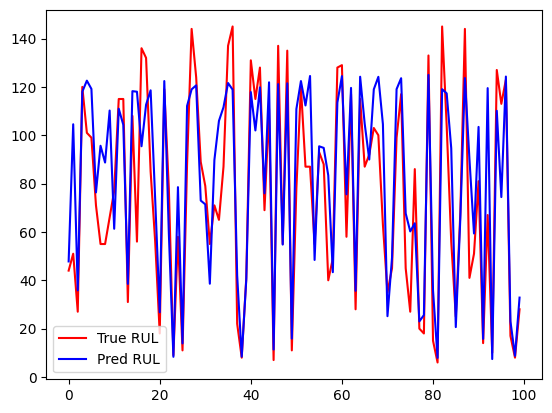

In [ ]:
# Plot true and predicted RUL values from XGBoost
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

We can also plot variable importance score.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

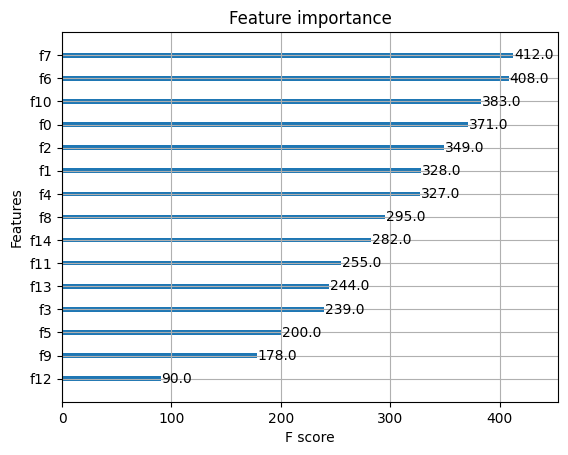

In [ ]:
xgb.plot_importance(bst_tuned)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5876.6821 - val_loss: 416.6951
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 337.8690 - val_loss: 278.9201
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 272.2445 - val_loss: 273.4389
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 270.7978 - val_loss: 270.7182
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 256.4290 - val_loss: 280.3461
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 256.0505 - val_loss: 259.6813
Epoch 7/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 245.8359 - val_loss: 247.4455
Epoch 8/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 252.0022 - val_loss: 248.3031
Epoch 9/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 253.3478 - val_loss: 251.0513
Epoch 10/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 242.8996 - val_loss: 243.2575
Epoch 11/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 246.5542 - val_loss: 247.

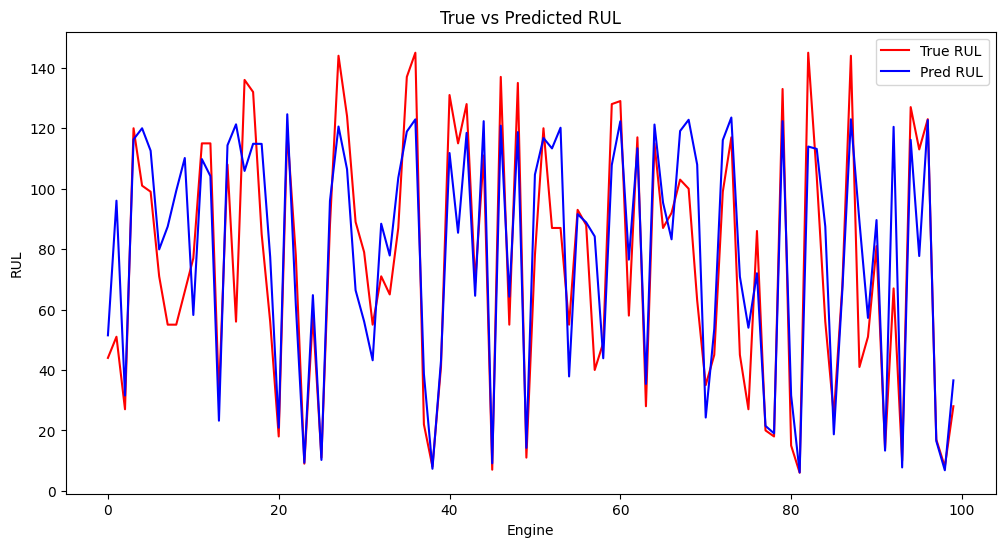

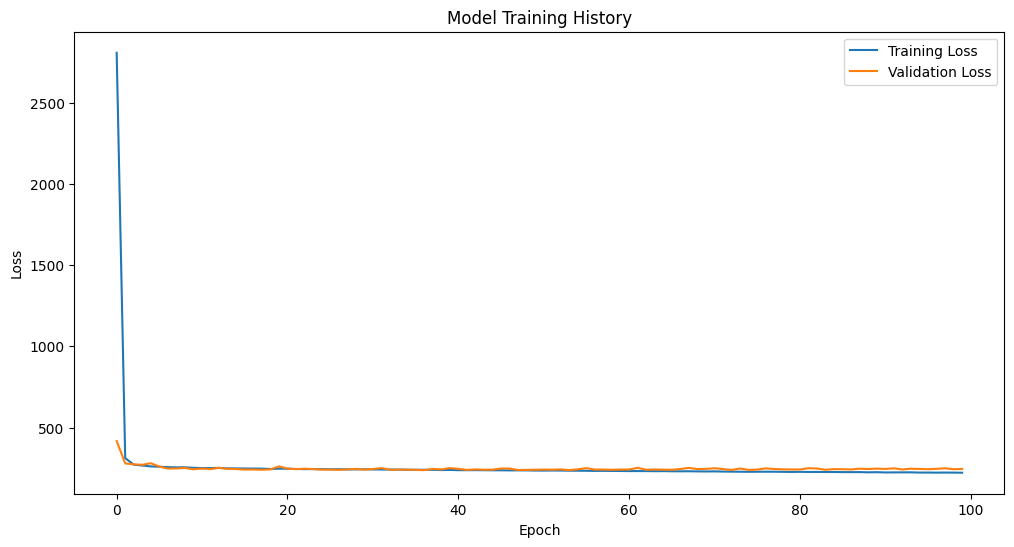

In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_length, processed_train_data.shape[2]), return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(processed_train_data, processed_train_targets, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
rul_pred = model.predict(processed_test_data).flatten()

# Process predictions
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights=np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

# Calculate RMSE
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

# Calculate S-score
def compute_s_score(rul_true, rul_pred):
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

# Plot true and predicted RUL values
plt.figure(figsize=(12, 6))
plt.plot(true_rul, label="True RUL", color="red")
plt.plot(preds_for_last_example, label="Pred RUL", color="blue")
plt.legend()
plt.title("True vs Predicted RUL")
plt.xlabel("Engine")
plt.ylabel("RUL")
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

